# Loading MNIST DATA

- 학번 :  20185124
- 전공 :  빅데이터 전공
- 이름 :  나영훈

In [260]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [261]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1000, shuffle=True)

In [262]:
images, labels = next(iter(trainloader))

In [263]:
images.shape #1000개의 배치 사이즈, 1은 흑백이기 때문에!

torch.Size([1000, 1, 28, 28])

In [264]:
torch.mean(images) # torch.mean(images[0]) 1, 2, 컬러면 이렇게 RGB 별로 떼서 사용.

tensor(0.1298)

In [265]:
torch.std(images)

tensor(0.3071)

In [266]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.13), (0.3)), #원래는 이거 RGB 별로 해야하는데.. 흑백이라서 하나!
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [267]:
images, labels = next(iter(trainloader))

In [268]:
images.shape

torch.Size([64, 1, 28, 28])

In [269]:
Xsample = images.reshape(images.shape[0], -1)
# 이미지를 64 * 784 형태의 2차원 shape로 만듬. 
# 784인 이유? 28 * 28 이니까

In [270]:
28*28

784

In [271]:
Xsample.shape

torch.Size([64, 784])

### Problem 1: Constructing the network model

`FNC` class를 정의하고 `model`을 생성하세요:

- input layer
  - number of input features를 hidden unit 128개로 선형변환 및 ReLU activation function
- Hidden layer
  - 128 hidden unit을 64개 hidden unit으로 선형변환 및 ReLU
- Output layer
  - 64개 hidden unit을 10개 class로 분류하기 위한 output layer
  - 최종 layer의 activation은 없음 (linear layer)

In [272]:
class FCN(nn.Module):
    # 답작성
    def __init__(self):
        super().__init__()
        self.seq =  nn.Sequential(
                    nn.Linear(Xsample.shape[1], 128),
                    nn.ReLU(True),
                    nn.Linear(128, 64),
                    nn.ReLU(True),
                    nn.Linear(64,10)
        )
    
    def forward(self,x):
        return self.seq(x)

In [273]:
model = FCN()
model

FCN(
  (seq): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

## Loss Functions in PyTorch

* 다음 과정으로, Pytorch에서 loss를 어떻게 연산하는지 배워보죠
* `nn` module에서 다양한 loss function을 제공하는데, 예를 들면 `nn.CrossEntropyLoss`와 같은 함수가 있습니다
    * 보통 관습적으로 loss function은 `critertion`이라는 변수로 받습니다 (`loss_function`등도 당연히 사용 가능합니다)
* 지난 시간에 MNIST 문제는 확률 분포를 output으로 받는 것이 필요하다고 (또는 자연스러운 선택 임을) 학습했습니다 
* 이런 확률 분포를 output으로 받는 경우 대응되는 좋은 loss function이 cross entropy입니다 (이론 강의에서 cross entropy가 무엇을 의미하는지 설명한 부분을 복습 해보세요)

* Cross entropy의 정의는 
\begin{align*}
 J(\theta) &=-\frac{1}{m}\sum_{i=1}^m P(y^{(i)}|x^{(i)})\log(Q(y^{(i)}|x^{(i)}))
\end{align*}
* 위 식은 두 확률 분포의 "거리"를 표현하는 식이라고 배웠습니다
* 위에서 $P(y|x)$는 $y$의 label을 one hot coding 한 vector이고 $Q(y|x)$는 softmax를 취한 network output입니다
* One hot coding은 label이 1이면 첫번째 자리만 '1'이고 나머지는 영인 벡터, label이 $k$이면 $k$ 번째 자리만 '1'이고 나머지는 0인 벡터입니다

* 예를들어서 label이 2에 대한 one hot encoding
\begin{align*}
y_\textrm{one_hot}(2) &= \begin{array}{cccccc}
[0 & 0 & 1 & \cdots & 0]
\end{array}
\end{align*}

* 위 cross entropy 식에 대응 하는 방식은, label이 2라고 가정했을 때 분포는:
\begin{align*}
P(y|x) = y_\textrm{one_hot}(2), \quad P(2|x) = (y_\textrm{one_hot}(2))_2
\end{align*}

* 또한, neural network의 마지막 linear layer의 output 값이 $z$라고 할때,
\begin{align*}
Q(y=2|x) = \sigma(z_2) = \cfrac{\exp(z_2)}{\sum_k^K{\exp(z_k)}}
\end{align*}

![Classnote](https://drive.google.com/uc?export=download&id=17hcl4RJne65Vd17gKM8XKUTjYlqyFIY5)

* pytorch에서 이를 수행하기 위해서 criterion을 `nn.CrossEntropyLoss`로 생성하고, network의 예측 값과, 실제 label 값을 입력으로 loss를 계산합니다
  * 본 과정은 차근차근 설명하겠습니다
* 그 전에 Pytorch에서 cross entropy 함수를 어떻게 적용하는지 먼저 이해할 필요가 있습니다 (중요합니다!!!)
  * [Pytorch.org `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss)를 살펴보면

> This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
>
> The input is expected to contain scores for each class.

* `nn.CrossEntropyLoss`는 `nn.LogSoftmax()`와 `nn.NLLLoss()` 하나의 class에서 수행한다고 되어 있습니다. 
* 두번째 줄에서 NLLLoss 는 negative log likelihood loss 입니다 

* 이게 의미하는 바가 무엇이냐면, network의 output을 softmax function을 적용하여 출력하지 말고, softmax는 loss function에서 계산한다는 뜻입니다
* 이렇게 구현한 이유는, 확률값이 작을 수 있어서 computation precision error를 방지하기 위해서 그냥 raw output 값을 받고, loss function에서 log(prob) 형태로 연산하도록 모듈을 구성하였습니다

* 아래 코드를 보면 조금 더 이해가 될 것이라고 생각합니다


In [274]:
criterion = nn.CrossEntropyLoss()
# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.reshape(images.shape[0], -1)

# Forward pass, get our log-probabilities
logits = model(images)
# Calculate the loss with the logps and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.2853, grad_fn=<NllLossBackward0>)


### Problem 2: Implement softmax

다음 `softmax` 함수를 만드세요

- `softmax(x)`
- `input`: (batchsize, num_class)의 최종 linear layer output
- `output`: `softmax` 취한 output이 (batchsize, softmaxoutput) 차원으로 정렬

- 유용할 수 있는 함수:
    - `torch.sum`
    - `torch.exp`
    - broadcasting 사용 (reshape)

In [275]:
logits.shape

torch.Size([64, 10])

In [276]:
labels

tensor([2, 9, 1, 8, 2, 1, 4, 0, 6, 4, 9, 9, 3, 7, 8, 6, 0, 8, 4, 8, 9, 8, 2, 5,
        2, 4, 6, 9, 3, 0, 5, 7, 3, 6, 1, 1, 4, 0, 4, 5, 3, 7, 8, 2, 5, 3, 9, 6,
        2, 6, 4, 9, 8, 9, 6, 5, 4, 7, 0, 4, 1, 3, 6, 7])

In [277]:
# F.softmax(logits, dim = 1) #원래 답과 비교.

In [278]:
# torch.sum(torch.exp(logits), axis = 1)

In [279]:
# 답작성
def softmax(x):
    return torch.exp(x)/torch.sum(torch.exp(x), axis = 1).reshape(-1,1)
    

In [280]:
ps = softmax(logits)
ps

tensor([[0.0795, 0.0988, 0.0920, 0.0908, 0.1025, 0.1156, 0.1267, 0.0869, 0.1086,
         0.0984],
        [0.0858, 0.1065, 0.0906, 0.0885, 0.1046, 0.1132, 0.1144, 0.0840, 0.1119,
         0.1006],
        [0.0906, 0.1034, 0.0913, 0.0911, 0.1085, 0.1157, 0.1130, 0.0884, 0.1032,
         0.0949],
        [0.0866, 0.0963, 0.0891, 0.0889, 0.1079, 0.1229, 0.1197, 0.0766, 0.1191,
         0.0931],
        [0.0890, 0.0977, 0.0967, 0.0899, 0.1063, 0.1133, 0.1046, 0.0957, 0.1054,
         0.1014],
        [0.0886, 0.1025, 0.0957, 0.0927, 0.1122, 0.1129, 0.1191, 0.0790, 0.1040,
         0.0935],
        [0.0772, 0.1181, 0.1058, 0.0959, 0.1114, 0.1080, 0.1129, 0.0789, 0.1004,
         0.0914],
        [0.0911, 0.0868, 0.0910, 0.0932, 0.1064, 0.1221, 0.1035, 0.0968, 0.1081,
         0.1009],
        [0.0819, 0.0937, 0.1051, 0.0903, 0.1091, 0.1159, 0.1227, 0.0797, 0.1054,
         0.0963],
        [0.0870, 0.0987, 0.1024, 0.0910, 0.1086, 0.1143, 0.1103, 0.0858, 0.1159,
         0.0860],
        [0

### Problem 3: Finding the Highest probability index

Sample별 예측 확률값을 통하여 가장 높은 확률 값 예측 받는 함수를 작성하세요.

`get_pred(ps)`
- `input`: sample 별 확률값을 (batchsize, class probabilities) 로 받음
- `output`: sample 별로 가장 높은 확률값의 index를 return

- 유용할 수 있는 함수
  - `torch.argmax`



In [281]:
def get_pred(ps):
    return torch.argmax(ps, axis = 1)
    

In [282]:
pred = get_pred(ps)
pred

tensor([6, 6, 5, 5, 5, 6, 1, 5, 6, 8, 6, 4, 5, 8, 8, 5, 5, 5, 4, 5, 6, 5, 6, 6,
        5, 6, 5, 5, 5, 8, 6, 5, 6, 5, 6, 4, 5, 6, 8, 6, 5, 8, 5, 5, 6, 5, 5, 5,
        6, 5, 4, 5, 5, 6, 5, 5, 5, 8, 5, 5, 6, 6, 6, 5])

# Calculating Gradients

- loss.`backward()`

In [283]:
print('Before backward pass: \n', model.seq[0].weight.grad)

loss.backward()

print('After backward pass: \n', model.seq[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005],
        [-0.0003, -0.0003, -0.0003,  ..., -0.0003, -0.0003, -0.0003],
        [ 0.0014,  0.0014,  0.0014,  ...,  0.0014,  0.0014,  0.0014],
        ...,
        [ 0.0003,  0.0003,  0.0003,  ...,  0.0003,  0.0003,  0.0003],
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        [ 0.0007,  0.0007,  0.0007,  ...,  0.0007,  0.0007,  0.0007]])


In [284]:
model.seq[0].weight.shape
#grad의 위치는 바뀌지 않음 각자의 위치에서 개선된 값을 적용시킬뿐.

torch.Size([128, 784])

In [285]:
model.seq[0].weight.grad.shape

torch.Size([128, 784])

## Training the network!


* 자, 그럼 network parameter에 대한 loss function의 gradient를 구했으니, 이제 최적화를 할 수 있습니다
* 최적화 기법은 SGD 이외에도 많으며 (SGD의 변형들임) [`optim` package](https://pytorch.org/docs/stable/optim.html)에서 찾아서 사용할 수 있습니다
* 예를 들어서 SGD는 `optim.SGD`를 통해서 불러올 수 있습니다
* 아래 예를 보죠

In [286]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
# 모델의 파라메타 넣고 learning rate 넣기.
optimizer = optim.SGD(model.parameters(), lr=0.1)

* model.parameters()는 우리 network의 모든 training parameter이며, lr는 learning rate 입니다
* 자, 이제 traning에 필요한 모든 부분이 준비되었습니다
* 전체 데이터에 대한 training은 숙제로 하고, 한 batch만 수행하는 과정을 살펴보죠
* Pytorch에서 training의 전체 흐름은 다음과 같습니다:

1. Network에서 forward pass
2. Foward pass를 통해서 얻은 output을 활용하여 loss를 구한다
3. Gradient를 구하기 위해서 `loss.backward()`를 실행한다
4. Optimizer에서 weight를 한번 update 한다 (SGD의 경우 gradient에 대해서 한번 update)

**[중요]**
* 한가지 주의할 점은, 한 Parameter들에 대해서 gradient를 여러개 구해야하는 경우, (예, batch 처리) gradient 값들은 계속 추가적으로 저장됩니다
* 한번 parameter update가 끝났으면, gradient 값을 초기화해야, 새로운 batch에 대한 새 gradient 값을 계산 합니다
* 이를 위해서 batch 시작시에 `optimizer.zero_grad()`를 실행해줘야합니다

In [287]:
print('Initial weights - ', model.seq[0].weight)

images, labels = next(iter(trainloader))
images = images.reshape(images.shape[0], -1) #이미지의 input값에 따라 달라지기 때문에 

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad() # update가 끝난 후 다시 계산을 해서 update를 해야 하기 때문! 
# 업데이트 안하면 계속 같은 값을 가지고 업데이트 하려나..? -> 이거는 case by case니까 찾아봐야겠다.

# Forward pass, then backward pass, then update weights
output = model(images) # Input이미지를 모델에 넣음.
loss = criterion(output, labels) # 1차적으로 모델의 CE를 게산함. -> for문이 아니기 때문에 대신 이 셀을 반복 실행하면 여러번 돌리는 것과 같겠지?
loss.backward() # backward를 통해 Gradient를 update함.
optimizer.step() #step을 통해 update된 gradient와 learning rate를 활용하여 적용한다.


print('Gradient -', model.seq[0].weight)

Initial weights -  Parameter containing:
tensor([[-0.0224,  0.0335, -0.0222,  ..., -0.0146, -0.0262,  0.0227],
        [-0.0259,  0.0014,  0.0350,  ...,  0.0175,  0.0046, -0.0150],
        [-0.0128, -0.0329, -0.0118,  ..., -0.0260, -0.0004,  0.0264],
        ...,
        [-0.0357,  0.0005,  0.0338,  ..., -0.0116,  0.0159, -0.0218],
        [-0.0305, -0.0165,  0.0262,  ..., -0.0235, -0.0333, -0.0247],
        [-0.0252, -0.0080,  0.0261,  ...,  0.0113, -0.0006, -0.0176]],
       requires_grad=True)
Gradient - Parameter containing:
tensor([[-0.0225,  0.0335, -0.0223,  ..., -0.0147, -0.0262,  0.0226],
        [-0.0258,  0.0014,  0.0350,  ...,  0.0175,  0.0046, -0.0149],
        [-0.0127, -0.0329, -0.0118,  ..., -0.0260, -0.0003,  0.0265],
        ...,
        [-0.0358,  0.0004,  0.0337,  ..., -0.0117,  0.0159, -0.0219],
        [-0.0306, -0.0166,  0.0261,  ..., -0.0236, -0.0334, -0.0248],
        [-0.0251, -0.0078,  0.0262,  ...,  0.0114, -0.0005, -0.0175]],
       requires_grad=True)


In [288]:
criterion = nn.CrossEntropyLoss() #엔트로피 로스 조사
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 20
loss_epoch = [] # Loss -> 예측값과 원래 data의 값의 차이 CE
acc_epoch = [] # 성공률 추적

for e in range(epochs):
    print(f"------ Starting epoch: {e} --------")
    running_loss = 0
    running_acc = 0

    for images, labels in trainloader: # iterator를 for문으로 돌림.
        images = images.reshape(images.shape[0], -1)
    
        logits = model(images)
        loss = criterion(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        ps = softmax(logits)
        pred = get_pred(ps)
        running_acc += torch.sum(pred==labels)/labels.shape[0] 
        
               
    acc_epoch.append(running_acc/len(trainloader))    
    loss_epoch.append(running_loss/len(trainloader))
    print(f"Training loss: {loss_epoch[e]}")
    print(f"Training acc: {acc_epoch[e]}")

------ Starting epoch: 0 --------
Training loss: 0.7698633656827117
Training acc: 0.8062366843223572
------ Starting epoch: 1 --------
Training loss: 0.31710633139874633
Training acc: 0.9074326753616333
------ Starting epoch: 2 --------
Training loss: 0.2608218531348685
Training acc: 0.9240738153457642
------ Starting epoch: 3 --------
Training loss: 0.22209677630777297
Training acc: 0.9355343580245972
------ Starting epoch: 4 --------
Training loss: 0.19260408198719087
Training acc: 0.9443796873092651
------ Starting epoch: 5 --------
Training loss: 0.1692448194537844
Training acc: 0.9519090056419373
------ Starting epoch: 6 --------
Training loss: 0.1503729875197511
Training acc: 0.956773042678833
------ Starting epoch: 7 --------
Training loss: 0.13515364472815858
Training acc: 0.9612040519714355
------ Starting epoch: 8 --------
Training loss: 0.12195252052553968
Training acc: 0.9653018116950989
------ Starting epoch: 9 --------
Training loss: 0.11121897033846645
Training acc: 0.96

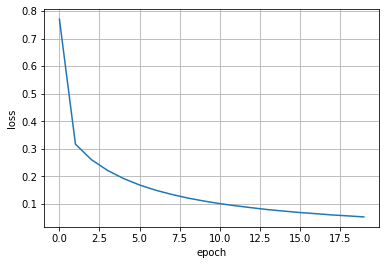

In [289]:
plt.plot(range(epochs), loss_epoch)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

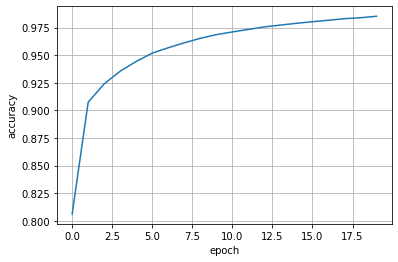

In [290]:
plt.plot(range(epochs), acc_epoch)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()

In [291]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

### 틀릭 예측 발견하기
이건 아무리 봐도 6인데.. 2라뇨... 이건 어쩔수 없었다..

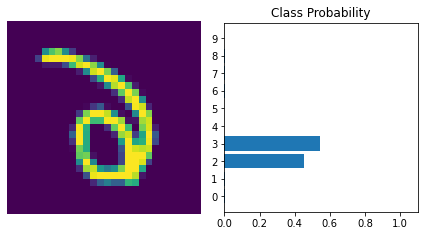

In [373]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = softmax(logps)
view_classify(img.view(1, 28, 28), ps)

In [376]:
labels[0]

tensor(2)